#### Визуализация латентного пространства (контекстные эмбеддинги cls токена модели rubert-tiny2)

In [ ]:
!pip install transformers umap-learn

In [1]:
import re
import umap
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
from utils import *

In [3]:
from google.colab import drive

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import SequentialSampler

In [5]:
from transformers import logging
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

In [6]:
def get_available_device():
    cuda = torch.cuda.is_available()
    return torch.device('cuda' if cuda else 'cpu')

In [ ]:
def umap_reduce_dim(X, n):
    params = {
        'min_dist': 0.1, 
        'metric': 'cosine', 
        'n_components': n, 
        'n_neighbors': 100, 
        'random_state': 42
    }
    return umap.UMAP(**params).fit_transform(X)

In [27]:
def scatter_plot(X2, y, labels):
    fig, ax = plt.subplots(figsize=(14,9))
    scatter = ax.scatter(X2[:,0], X2[:,1], c=y, s=2, cmap='tab20')
    ax.legend(handles=scatter.legend_elements()[0], labels=labels)

In [ ]:
def clean(s):
    s = re.sub('\n', ' ', s)
    s = re.sub('<\?xml.+\?>', ' ', s)
    s = re.sub('<\/?[A-Za-z]*>', ' ', s)
    s = re.sub('[0-9]+(\.|,)?[0-9]*', ' num ', s)
    s = re.sub('([a-zа-яёй])([A-ZА-ЯЁЙ])', '\g<1> \g<2>', s)
    s = re.sub('[^A-Za-zА-ЯЁЙа-яёй0-9.,;:!?()"\s\-\']', ' ', s)
    return re.sub('\s{2,}', ' ', s).strip()

In [10]:
def tokenize(titles, texts, tokenizer):
    
    params = {'max_length': 512, 
              'truncation': True, 
              'padding': 'max_length', 
              'add_special_tokens': True}
    
    input_ids = torch.zeros((len(titles), 512), dtype=torch.int32)
    
    for i in tqdm(range(len(titles))):
        title, text = clean(titles[i]), clean(texts[i])
        ids = tokenizer.encode(title, text, **params)
        input_ids[i] = torch.tensor(ids, dtype=torch.int32)
    
    return input_ids

In [11]:
def load_model(name, path):
    
    params = {
        'num_labels': 6, 
        'output_attentions': False, 
        'output_hidden_states': True
    }
    
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModelForSequenceClassification.from_pretrained(name, **params)
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    return model, tokenizer

In [12]:
def get_cls_embs(model, loader, device, pad_token_id=0):
    
    cls_embs = []
    model = model.eval()
    model = model.to(device)
    torch.set_grad_enabled(False)
    
    for batch in tqdm(loader):
        
        input_ids = batch[0].to(device)
        attn_mask = (input_ids != pad_token_id)
        
        params = {
            'output_attentions': False, 
            'output_hidden_states': True, 
            'attention_mask': attn_mask, 
            'input_ids': input_ids
        }
        
        output = model(**params)
        cls_embs.append(output['hidden_states'][-1][:,0,:].cpu())
    
    return torch.vstack(cls_embs)

* *фунция извлечения эмбеддингов документов (cls токен последнего слоя)*

In [ ]:
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/shared/topic/data.zip -d data

* *загружаем и извлекаем данные (сейчас мы на google colab - нам нужен GPU)*

In [13]:
logging.set_verbosity_error()

In [14]:
model, tokenizer = load_model('cointegrated/rubert-tiny2', 'data/rubert2.pt')

* *загружаем модель и токенизитор, подгружаем лучшие веса*

In [15]:
df = pd.read_csv('data/raw.csv')
df = df.sample(40000, random_state=42)
labels = list(load_json('data/labels.json').keys())
df['topic'] = df['topic'].map(load_json('data/labels.json'))
input_ids = tokenize(df['title'].values, df['text'].values, tokenizer)

  0%|          | 0/40000 [00:00<?, ?it/s]

* *загружаем семпл из 40к объектов и токенизируем их*

In [16]:
dataset = TensorDataset(input_ids)

In [17]:
loader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=32)

In [18]:
device = get_available_device()
cls_embs = get_cls_embs(model, loader, device, tokenizer.pad_token_id)

  0%|          | 0/1250 [00:00<?, ?it/s]

In [19]:
input_ids.shape, len(dataset), len(loader), cls_embs.shape

(torch.Size([40000, 512]), 40000, 1250, torch.Size([40000, 312]))

* *получаем 40к эмбеддингов документов, по 312 фич каждый*

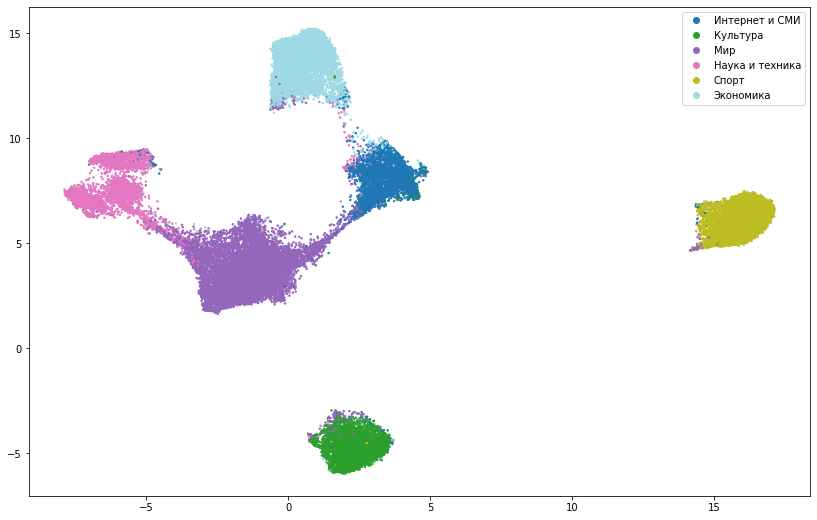

In [28]:
scatter_plot(umap_reduce_dim(cls_embs, 2), df['topic'].to_numpy(), labels)

* *визуализируем эмбеддинги документов*
* *кластеры классов документов видны еще лучше :)*